In [1]:
# ------ Importações gerais e Funções
import warnings
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn import metrics

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True, precision=4)

# ------ Funções

# Função para manipulação das datas
def separa_datas(df, col):
    temp = pd.DataFrame()
    print('\nResgatando informações do dataframe...')
    temp[col] = pd.to_datetime(df[col], format='%b-%Y')
#    dias = []  # cria lista vazia para ser preenchida com a informação dos dias
    mes_ano = []  # cria lista vazia para ser preenchida com mês/ano

    if temp[col].isnull().sum() > 0:
        print(f'\nATENÇÃO! Identificadas NaNs na feature {col}, impossível continuar.')
        print(f'Favor resolver as {temp[col].isnull().sum()} NaNs antes de tentar novamente. Seu bosta.')
    else:
        print('\nSeparando parâmetros de data e gerando nova série, só um instante por favor.')
        for i in range(0, len(temp)):  # preenche a lista com mês e ano
            mes_ano.append(temp.loc[i, col].strftime('%b-%Y').lower())
        print('\nTudo pronto.')

        return pd.Series(data=mes_ano, name='mes_ano')  # retorna uma série nova



# Função para buscar a explicação de cada feature no dicionário e analisar NaNs
def analise_geral(lista, dataframe: pd.DataFrame):
    """
    :param lista: lista de features a se verificar
    :dtype lista: list
    :param dataframe: o banco de dados que contem todas as features que serão verificadas
    :type dataframe: DataFrame
    """
    def significado(x: object):
        dic = pd.read_csv('./data/dictionary.csv', index_col=False)
        print(f'Nome: {str(x).upper()}')
        print(f'Definição: {dic[dic['Feature'] == str(x)]['Descrição'].values}')

    if len(lista) > 1:
        for i in range(0, len(lista)):
            print('\n')
            print(f'Feature #{i+1}/{len(lista)}')
            significado(lista[i])
            print(f'Tipo de dado: {str(dataframe[lista[i]].dtypes).upper()}')
            print(f'Quantidade total de NaNs: {dataframe[lista[i]].isnull().sum()}')
            print(f'Proporção desses NaNs: {round((dataframe[lista[i]].isnull().sum()/len(dataframe))*100, 2)}%')
    elif len(lista) == 1:
        print('\n')
        significado(lista[0])
        print(f'Tipo de dado: {str(dataframe[lista[0]].dtypes).upper()}')
        print(f'Quantidade total de NaNs: {dataframe[lista[0]].isnull().sum()}')
        print(f'Proporção desses NaNs: {round((dataframe[lista[0]].isnull().sum()/len(dataframe))*100, 2)}%')



# Função que analisa apenas as features sem NaNs
def analise_nans(lista, dataframe: pd.DataFrame):
    """
    :param lista: lista de features a se verificar
    :dtype lista: list
    :param dataframe: o banco de dados que contem todas as features que serão verificadas
    :type dataframe: DataFrame
    """
    def significado(x: object):
        dic = pd.read_csv('./data/dictionary.csv', index_col=False)
        print(f'Nome: {str(x).upper()}')
        print(f'Definição: {dic[dic['Feature'] == str(x)]['Descrição'].values}')
    print('\nVerificando...')

    if len(lista) > 1:
        if any(dataframe[lista].isnull().sum() > 1) == False:
            print('==> Sem NaNs nessa lista, parabéns.')
        else:
            print('Calculando tamanho da solicitação, só um instante por favor.')
            tam = len(dataframe[lista].isnull().sum()[dataframe[lista].isnull().sum() > 0])
            idx = 1
            for i in range(0, len(lista)):
                if dataframe[lista[i]].isnull().sum() == 0:
                    pass
                else:
                    print('\n')
                    print(f'Feature #{idx}/{tam}')
                    significado(lista[i])
                    print(f'Tipo de dado: {str(dataframe[lista[i]].dtypes).upper()}')
                    print(f'Quantidade total de NaNs: {dataframe[lista[i]].isnull().sum()}')
                    print(f'Proporção desses NaNs: {round((dataframe[lista[i]].isnull().sum()/len(dataframe))*100, 2)}%')
                    idx += 1
    elif len(lista) == 1:
        if dataframe[lista[0]].isnull().sum() == 0:
            print('==> Sem NaNs nessa lista, parabéns.')
        else:
            print('\n')
            significado(lista[0])
            print(f'Tipo de dado: {str(dataframe[lista[0]].dtypes).upper()}')
            print(f'Quantidade total de NaNs: {dataframe[lista[0]].isnull().sum()}')
            print(f'Proporção desses NaNs: {round((dataframe[lista[0]].isnull().sum()/len(dataframe))*100, 2)}%')



# Função para armazenar os valores de média e desvio padrão das features, para normalização dos valores
def parametros_zscore(df: pd.DataFrame, norm:list):
    """
    Args: df = DataFrame contendo os dados que serão utilizados
          norm = lista com a relação das features que precisam passar por normalização. Caso
                 norm=False a função utiliza as features do DataFrame original

    Returns: DataFrame contendo os valores de média e desvio padrão de cada feature; lista
            contendo o nome das features utilizadas
    """
    if norm:
        pass
    else:
    # Normalização apenas das colunas originais, sem contar as categóricas (como 'fez_hardship', por exemplo)
        norm = ['EFFR', 'expec6m', 'expec12m', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
            'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
            'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
            'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
            'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
            'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
            'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
            'mths_since_rcnt_il', 'total_rev_hi_lim', 'inq_fi', 'acc_open_past_24mths', 'avg_cur_bal',
            'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
            'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc','mths_since_recent_bc',
            'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats',
            'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
            'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
            'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort',
            'total_bc_limit', 'total_il_high_credit_limit', 'tempo_total_tomador', 'tempo_consulta',
            'orig_projected_additional_accrued_interest', 'deferral_term', 'hardship_amount', 'hardship_length',
            'hardship_dpd', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'tempo_total_contrato',
            'tempo_payment_plan', 'annual_inc_joint', 'dti_joint', 'revol_bal_joint', 'sec_app_fico_range_low',
            'sec_app_fico_range_high', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc',
            'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
            'sec_app_collections_12_mths_ex_med']

    new_df = {}
    for name in norm:
        media = df[name].mean()
        desvio = df[name].std()
        new_df.update({name: {
                            'Media': media,
                            'DesvPadrao': desvio,
                            }
    })

    return pd.DataFrame(new_df), norm


# Função de ZScore personalizada
def tcc_zscore(df:pd.DataFrame, norm:list):
    from scipy import stats
    """
    Args: df = DataFrame contendo os dados para normalização
          norm = lista contendo o nome de cada feature para normalização
    """
    try:
        print('Iniciando processo de normalização.\n')
        for name in norm:
            df[name] = stats.zscore(df[name])
        print('Processo de normalização concluído com sucesso!')
    except Exception as e:
        print(f'O seguinte erro ocorreu durante a tentativa de padronização por ZScore: {e}. Favor verificar')


# Função de carregamento (parcial ou integral) do banco de dados
def carregamento_treino(percentual=1):
    print('Carregando banco de dados de treino completo...')
    try:
        modelagem = pd.read_parquet('data/modelagem.parquet')
    except Exception as e:
        print(f'Erro no carregamento: {e}. Favor verificar.')
        
    # O PC não conseguia processar o arquivo inteiro no modelo de LDA, optei por testar com apenas as 70% observações iniciais
    # O processamento com 70% produz resultado, com utilização de 100% CPU e 99% RAM durante o treino
    if (percentual < 1) and (percentual > 0):
        print('Realizando redução das observações.')
        treino_manter, treino_deletar = train_test_split(modelagem, train_size=percentual, random_state=1)
        print('Liberando memória.')
        del treino_deletar, modelagem

        print('Realizando separação variáveis dependente e independentes.')
        target = ['default']
        test_data = treino_manter[target]
        train_data = treino_manter.drop(target, axis = 1)
        del treino_manter
        print('Carregamento do banco de dados concluído.')
        
    elif percentual > 0:
        print('Banco de dados carregado com sucesso, separando variáveis dependente e independentes.')
        target = ['default']
        test_data = modelagem[target]
        train_data = modelagem.drop(target, axis = 1)
        del modelagem
        print('Carregamento do banco de dados concluído.')
    else:
        print('Favor registrar um percentual em decimais, entre 0 (exclusive) e 1 (inclusive).')
        test_data = None
        train_data = None
    
    return train_data, test_data


# Análise das métricas e geração da matriz de confusão
def analise_metricas(classif=None, X=pd.DataFrame, y=pd.Series, color='Oranges'):
    """
    Args:
    - classif: o algoritmo utilizado (o objeto que processa o .fit)
    - X: DataFrame (normalmente teste_x)
    - y: Series (normalmente teste_y)
    """
    if not classif:
        print('Necessário treinamento do modelo antes de se poder calcular as métricas')
    else:
        # ------ Cálculo das métricas do modelo
        print('Realizando a previsão dos valores do banco de dados e calculando as métricas de avaliação.\n')
        inicio_prev = timer()
        ypred = classif.predict(X).astype(int)  # previsão dos dados de teste, astype garante que o output não seja float (caso do TF)
        acc = accuracy_score(y, ypred)  # cálculo accuracy (eficiência geral do modelo)
        sens = recall_score(y, ypred, pos_label=1)  # cálculo da sensitividade/recall (taxa de acerto dos eventos)
        spec = recall_score(y, ypred, pos_label=0)  # cálculo da especificidade (taxa de acerto dos não-eventos)
        prec = precision_score(y, ypred)  # taxa de acerto dos positivos totais (TP/(TP+FP))
        fim_prev = timer()

        print(f'Análise do modelo:\n')
        print(f'Valor métrica Accuracy:: {acc:.6f}')
        print(f'Valor métrica Sensitividade (Recall): {sens:.6f}')
        print(f'Valor métrica Especificidade: {spec:.6f}')
        print(f'Valor métrica Precision: {prec:.6f}')
        print(f'Tempo de cálculo {timedelta(seconds=fim_prev-inicio_prev)}.')
        print('\n')


        # ------ Matriz de confusão
        conf_matrix = metrics.confusion_matrix(y.default.values.astype('int'), ypred, labels=[1, 0])
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_matrix,
                    fmt='d',
                    annot=True,
                    cmap=color,
                    xticklabels=['Inadimplentes', 'Em dia'],
                    yticklabels=['Inadimplentes', 'Em dia'])
        plt.title(f'Matriz de Confusão', fontsize=12)
        plt.xlabel('Dados observados', fontsize=12)
        plt.ylabel('Dados previstos', fontsize=12)
        plt.show()

        return ypred

In [2]:
# 1. DATA WRANGLING: INFORMAÇÕES DOS CONTRATOS
#=========================

# Leitura do arquivo com as informações dos contratos
emprestimos = pd.read_csv('./data/loans2020.csv', low_memory=False) # hiperparâmetro 'low_memory' aqui apenas para não retornar aviso no console

# Ajuste de duas features enquadradas como 'object' em função de notação percentual
emprestimos['revol_util'] = emprestimos['revol_util'].str.replace('%', '').astype('float64')
emprestimos['int_rate'] = emprestimos['int_rate'].str.replace('%', '').astype('float64')

# Algumas observações em revol_util não estão corretas (cálculo revol_bal/total_rev_hi_lim). Empiricamente
# a ocorrência de registros diferentes é de menos de 3% do total, então opta-se por recalcular toda a feature revol_util
utilizado = emprestimos['revol_bal']
total = emprestimos['total_rev_hi_lim']
revol_util = utilizado/total
emprestimos['revol_util'] = revol_util

# Dropa algumas features que não serão utilizadas durante todo o processo
dropar = ['Unnamed: 0', 'url', 'zip_code', 'id', 'policy_code']  # features sem utilização no contexto deste estudo
emprestimos.drop(dropar, axis=1, inplace=True)

# A feature 'loan_status' contem as informações necessárias:
# - Fully paid: empréstimos quitados
# - Current: empréstimos ativos
# - Charged off: empréstimos vencidos já reclassificados como prejuízo
# - Late (31-120 days): empréstimos em atraso
# - In Grace Period: empréstimos atrasados mas que ainda podem ser pagos sem ônus, neste estudo considera-se este enquadramento
#                    como período entre 1-15 dias de atraso, dadas as demais características do banco de dados
# - Late (16-30 days): empréstimos em atraso
# - Does not meet the credit policy (ambos): descartados? não atendem a política de crédito - vai saber
# - Default: empréstimos atrasados a mais de 120 dias mas ainda não enquadrados em prejuízo
#emprestimos['loan_status'].value_counts()

# Esse estudo se propõe a analisar o risco de atraso de uma operação no tocante à questão de prejuízo à instituição financeira.
# Para tanto, serão considerados os empréstimos cujos loan_status estejam enquadrados em default ou pior, pois assume-se que os
# contratos que possuem atraso de até 120 dias possuam uma chance razoável de recebimento por parte da instituição, bem como na
# literatura em inglês o estudado é o risco efetivo de default, não o risco de atraso.


In [3]:
# 2. EXPLORATORY DATA ANALYSIS (EDA)
#=========================

# Verificando as features com maiores % de valores NaN:
# 29 features com NaNs acima de 90% do total de observações;
# 35 acima de 50% das observações;
# 35 acima de 40% das observações;
# 37 acima de 30% das observações;
# 49 acima de 29% das observações.
# Para verificação:
# len(emprestimos.isnull().sum()[emprestimos.isnull().sum()/emprestimos.shape[0] > 0.3])

# Dada a alteração na quantidade de variáveis entre 37 e 40% de NaNs, opta-se por eliminar o menor número possível
# entre essas duas, logo, as features com quantidade de NaNs equivalente a 40% ou mais das observações terão
# atenção maior na tentativa de imputar valores faltantes
feature_drop = emprestimos.isnull().sum()[emprestimos.isnull().sum()/emprestimos.shape[0] > 0.3].index.values

# Análise individual de cada uma dessas features
#analise_geral(feature_drop, emprestimos)

# Seleção das features de renegociação (15 variáveis no total)
hard_cols = []
hard_cols.append(feature_drop[34])  # essas três features não possuem 'hardship' no nome, então são
hard_cols.append(feature_drop[30])  # inseridas manualmente
hard_cols.append(feature_drop[26])
for hardship in emprestimos.columns.to_list():
    if "hardship" in hardship:
        hard_cols.append(hardship)

# Seleção das features de aplicação conjunta (15 variáveis)
sep_ap = []
for other_applicant in emprestimos.columns.to_list():
    if "sec_app_" in other_applicant:
        sep_ap.append(other_applicant)
    if "joint" in other_applicant:
        sep_ap.append(other_applicant)


# Segregando features de aplicação conjunta e de renegociação
joint_ap = emprestimos[sep_ap].copy()
emprestimos.drop(sep_ap, axis=1, inplace=True)

hardships = emprestimos[hard_cols].copy()
emprestimos.drop(hard_cols, axis=1, inplace=True)

# Salva as informações de forma individual em Parquet (mais rápido, menos espaço)
hardships.to_parquet('data/hardships.parquet')
joint_ap.to_parquet('data/joint_ap.parquet')
emprestimos.to_parquet('data/emprestimos_dropado.parquet')

In [4]:
# 3. DATA WRANGLING: TRATAMENTO DOS CONTRATOS COM RENEGOCIAÇÃO
#=========================
#hardships = pd.read_parquet('data/hardships.parquet')
hard_cols = hardships.columns.to_list()

# Relembrando cada uma das features
#analise_geral(hard_cols, hardships)

# Parte-se do princípio que quem não tenha status definido de hardship é em função de não ter realizado acordo algum
mask = hardships['hardship_loan_status'].isnull() == False

# Criando feature nova identificando quais contratos tem renegociação
hardships['fez_hardship'] = 0
hardships.loc[mask, 'fez_hardship'] = 1

# Verificação de NaNs dentro destes que fizeram hardship
hardships.loc[mask].isnull().sum()[hardships.loc[mask].isnull().sum() > 0]

# hardship_flag preenchendo com a moda ('N')
hardships.loc[mask, 'hardship_flag'] = hardships.loc[mask, 'hardship_flag'].fillna('N')

# hardship_status preenchendo com 'ACTIVE'
hardships.loc[mask, 'hardship_status'] = hardships.loc[mask, 'hardship_status'].fillna('ACTIVE')

# hardship_reason preenchendo com 'Unknown', não foi percebido padrão
hardships.loc[mask, 'hardship_reason'] = hardships.loc[mask, 'hardship_reason'].fillna('UNKNOWN')

# orig_projected_additional_accrued_interest preenchido com zero, em função de 'hardship_type'
hardships.loc[mask, 'orig_projected_additional_accrued_interest'] = hardships.loc[mask, 'orig_projected_additional_accrued_interest'].fillna(0)


# Todas as features com dtypes numéricos terão fillna(0).
lista = hardships.dtypes[hardships.dtypes == 'float64'].index.to_list()
hardships[lista] = hardships[lista].fillna(0)


# Todas as features com dtypes categóricos terão fillna específico
lista = hardships.dtypes[hardships.dtypes == 'object'].index.to_list()
hardships['hardship_flag'] = hardships['hardship_flag'].fillna('N')  # não tem motivo por ter sido flaggado
hardships[lista] = hardships[lista].fillna('Not Applicable')


# A feature hardship_reason tem classes repetidas, com grafia diferente. De repente pode ser unido DISABILITY com MEDICAL também.
# Ajuste abaixo.
mask = hardships['hardship_reason'] == 'INCOMECURT'
hardships.loc[mask, 'hardship_reason'] = 'INCOME_CURTAILMENT'

mask = hardships['hardship_reason'] == 'UNEMPLOYED'
hardships.loc[mask, 'hardship_reason'] = 'UNEMPLOYMENT'

mask = hardships['hardship_reason'] == 'REDCDHOURS'
hardships.loc[mask, 'hardship_reason'] = 'REDUCED_HOURS'

mask = hardships['hardship_reason'] == 'NATDISAST'
hardships.loc[mask, 'hardship_reason'] = 'NATURAL_DISASTER'

mask = hardships['hardship_reason'] == 'EXCESSOBLI'
hardships.loc[mask, 'hardship_reason'] = 'EXCESSIVE_OBLIGATIONS'

mask = hardships['hardship_reason'] == 'FINANCIAL'  # Agregando 'financial' em 'excessive_obligations' pois, via de regra, tem a mesma causa
hardships.loc[mask, 'hardship_reason'] = 'EXCESSIVE_OBLIGATIONS'

mask = hardships['hardship_reason'] == 'DEATH'  # Agregando 'death' em 'family_death', deduz-se que o falecido não vai pedir renegociação do próprio contrato
hardships.loc[mask, 'hardship_reason'] = 'FAMILY_DEATH'

# Trabalhar com uppercase é desconfortável, ajustando:
for i in range(0, len(lista)):
    hardships[lista[i]] = hardships[lista[i]].str.lower()

# Quando realizada a renegociação, o status dessa renegociação é que passará a ser o target do modelo. São consideradas operações
# inadimplidas as com status 'incollection' (terceirizada), 'delinquent' (inadimplente), e 'issued' (registrada como inadimplida rumo a prejuízo)
inad = ['incollection', 'delinquent', 'issued']

# Criação do target:
mask = hardships['hardship_loan_status'].isin(inad)  # máscara para identificação dos contratos não-pagos
hardships['hardship_default'] = 0  # criação da feature de target
hardships.loc[mask, 'hardship_default'] = 1  # registro dos contratos não-pagos
hardships.drop('hardship_loan_status', axis=1, inplace=True)  # dropa a variável referência do target

# Para a criação de novas variáveis contemplando os prazos de renegociação primeiro precisa-se transformar as features de
# base em datetime[ns], para tanto os valores 'not applicable' serão substituídos pelo mês 'jan-2125' apenas como facilitador
# do cálculo para depois ajustar esses valores corretamente
feats = ['hardship_end_date', 'hardship_start_date', 'payment_plan_start_date']
for feat in feats:
    mask = hardships[feat] == 'not applicable'
    hardships.loc[mask, feat] = 'jan-2125'
    hardships[feat] = pd.to_datetime(hardships[feat], format='%b-%Y')

# Criação de nova feature com o tempo total do contrato de renegociação
anos = (hardships['hardship_end_date'].dt.year - hardships['hardship_start_date'].dt.year)*12
meses = hardships['hardship_end_date'].dt.month - hardships['hardship_start_date'].dt.month
tempo_contrato = anos + meses
hardships['tempo_total_contrato'] = tempo_contrato

# Criação de nova feature, de tempo total de de payment_plan
anos = (hardships['hardship_end_date'].dt.year - hardships['payment_plan_start_date'].dt.year)*12
meses = hardships['hardship_end_date'].dt.month - hardships['payment_plan_start_date'].dt.month
tempo_payment = anos + meses
hardships['tempo_payment_plan'] = tempo_payment

# Colunas de data já utilizadas, pode-se dropar
hardships.drop(feats, axis=1, inplace=True)

# Salva alterações em disco
hardships.to_parquet('data/hardships_wrangled.parquet')

In [5]:
# 4. DATA WRANGLING: TRATAMENTO DOS CONTRATOS COM APLICAÇÃO CONJUNTA
#=========================
joint_ap = pd.read_parquet('data/joint_ap.parquet')
#sep_ap = joint_ap.columns.to_list()

# Criação de indicador de contrato com composição de renda
mask = joint_ap['annual_inc_joint'].isnull()
joint_ap['contrato_conjunto'] = 0
joint_ap.loc[~mask, 'contrato_conjunto'] = 1

# Verificação dos dtypes 'object' primeiro:
lista = joint_ap.dtypes[joint_ap.dtypes == 'object'].index.to_list()

# As observações de 'verification_status_joint' (lista[0]) com NaN que foram
# identificadas como contrato conjunto terão fillna('Not Verified')
mask = joint_ap['contrato_conjunto'] == 1

# Preenche primeiro os contratos marcados como conjuntos
joint_ap.loc[mask, lista[0]] = joint_ap.loc[mask, lista[0]].fillna('Not Verified')

# Em seguida preenche os demais contratos com 'Not Applicable'
joint_ap[lista[0]] = joint_ap[lista[0]].fillna('Not Applicable')

# A outra feature categórica, 'sec_app_earliest_cr_line' (lista[1]),
# refere-se à data do primeiro empréstimo tomado pelo segundo proponente.
# Como é impossível essa estimação, toma-se a data do contrato em pleito
# como data de primeiro empréstimo.
valores = emprestimos.loc[mask][joint_ap.loc[mask, lista[1]].isnull()]['issue_d'].values
indices = emprestimos.loc[mask][joint_ap.loc[mask, lista[1]].isnull()]['issue_d'].index.to_list()
joint_ap.loc[indices, lista[1]] = valores

# O restante das NaNs substitui-se por 'Not Applicable'
joint_ap[lista[1]] = joint_ap[lista[1]].fillna('Not Applicable')

# Em seguida, verificação dos dtypes float64
lista = joint_ap.dtypes[joint_ap.dtypes == 'float64'].index.to_list()

# Primeiro os contratos que são individuais serão preenchidos com zero
mask = joint_ap['contrato_conjunto'] == 0
joint_ap[mask] = joint_ap[mask].fillna(0)

# Trata-se individualmente as variáveis dos contratos conjuntos
mask = joint_ap['contrato_conjunto'] == 1

# Explicação das features que necessitam ajuste
#analise_geral(lista, joint_ap)

# NaNs na feature dti_joint assumem o valor de dti
indices = joint_ap[joint_ap[lista[1]].isnull()][lista[1]].index.to_list()
valores = emprestimos.iloc[indices]['dti'].values
joint_ap.loc[indices, lista[1]] = valores

# revol_bal_joint assume o valor de revol_bal
indices = joint_ap[joint_ap[lista[2]].isnull()][lista[2]].index.to_list()
valores = emprestimos.iloc[indices]['revol_bal'].values
joint_ap.loc[indices, lista[2]] = valores

# sec_app_revol_util assume o valor de revol_util
indices = joint_ap[joint_ap[lista[8]].isnull()][lista[8]].index.to_list()
valores = emprestimos.iloc[indices]['revol_util'].values  # existem NaNs no dataset original, depois se lida com isso
joint_ap.loc[indices, lista[8]] = valores

indices = joint_ap[joint_ap[lista[8]].isnull()][lista[8]].index.to_list() # refazendo índice, ainda ficam 53 NaNs
lista = joint_ap.isnull().sum()[joint_ap.isnull().sum() > 53].index.to_list()

# As fico ranges copia-se do mutuário principal, uma vez que é impossível estimar. Pode-se partir da
# premissa que muito embora o segundo mutuário não seja idêntico ao primeiro eles devem possuir
# hábitos e comportamentos semelhantes na grande maioria das vezes.

idx_conj = joint_ap[joint_ap['contrato_conjunto'] == 1].index.to_list()  # armazena os índices de todos contratos conjuntos
vazios = joint_ap.loc[idx_conj][joint_ap.loc[idx_conj, lista[0]].isnull()].index.to_list()  # filtra apenas os vazios em sec_app_fico_range_low
joint_ap.loc[vazios, lista[0]] = emprestimos.loc[vazios, 'fico_range_low']  # registra o score do primeiro proponente também no segundo

idx_conj = joint_ap[joint_ap['contrato_conjunto'] == 1].index.to_list()  # armazena os índices de todos contratos conjuntos
vazios = joint_ap.loc[idx_conj][joint_ap.loc[idx_conj, lista[1]].isnull()].index.to_list()  # filtra apenas os vazios em sec_app_fico_range_high
joint_ap.loc[vazios, lista[1]] = emprestimos.loc[vazios, 'fico_range_high']  # registra o score do primeiro proponente também no segundo

# As demais features (com exceção de sec_app_revol_util) são variáveis discretas sobre consultas a cadastro,
# quantidade de recuperações de dívidas, hipotecas, etc., do segundo proponente. NaNs preenchidos com zero:
zeros = joint_ap.isnull().sum()[joint_ap.isnull().sum() > 53].index.to_list()
joint_ap[zeros] = joint_ap[zeros].fillna(0)

# Salva alterações em disco
joint_ap.to_parquet('data/joint_ap_wrangled.parquet')

In [ ]:
# 5. DATA WRANGLING: TRATAMENTO DAS DEMAIS FEATURES CATEGÓRICAS
#=========================
#emprestimos = pd.read_parquet('data/emprestimos_dropado.parquet')

# Ajuste feature 'term' (prazo) para numérica
emprestimos['term'] = emprestimos['term'].replace({emprestimos.loc[0, 'term']: 36, emprestimos.loc[1, 'term']: 60})

# 'tax_liens' se preenche com zeros, como não tem como estimar essa informação então
# parte-se do princípio que o tomador não tenha essa recuperação judicial
emprestimos['tax_liens'] = emprestimos['tax_liens'].fillna(0)

# As observações em 'next_pymnt_d' são todas ou liquidadas ou transferidas para prejuízo
mask = emprestimos['next_pymnt_d'].isnull()
#emprestimos.loc[mask, 'loan_status'].value_counts()  # caso seja necessária a verificação

# Criação dos índices dos contratos e substituição dos NaNs
pagos = emprestimos.loc[mask, 'loan_status'][emprestimos.loc[mask, 'loan_status'] == 'Fully Paid'].index.values
pagos = emprestimos.iloc[pagos]['next_pymnt_d'].fillna('fully_paid')
emprestimos['next_pymnt_d'] = emprestimos['next_pymnt_d'].fillna(pagos)

prejuizo = emprestimos.loc[mask, 'loan_status'][emprestimos.loc[mask, 'loan_status'] == 'Charged Off'].index.values
prejuizo = emprestimos.iloc[prejuizo]['next_pymnt_d'].fillna('charged_off')
emprestimos['next_pymnt_d'] = emprestimos['next_pymnt_d'].fillna(prejuizo)

# 'mths_since_rcnt_il': se não existe informação sobre a última concessão de crédito
# ao tomador, infere-se que o contrato vigente foi o último na análise. Logo, fillna(-1)
emprestimos['mths_since_rcnt_il'] = emprestimos['mths_since_rcnt_il'].fillna(-1)

# 'emp_length' fillna('Unknown'), não tem como inferir tempo de emprego dos proponentes
emprestimos['emp_length'] = emprestimos['emp_length'].fillna('Unknown')

# 'earliest_cr_line' também não tem como inferir data do primeiro crédito concedido
# ao tomador, então  utiliza-se este como referência
mask = emprestimos['earliest_cr_line'].isnull()
earliest = emprestimos.loc[mask, 'issue_d']
emprestimos['earliest_cr_line'] = emprestimos['earliest_cr_line'].fillna(earliest)

# 'emp_title' fillna('Unknown'), impossível inferir cargo do proponente
emprestimos['emp_title'] = emprestimos['emp_title'].fillna('Unknown')

# 'title' - nome do empréstimo. Já tem uma feature com o objetivo do empréstimo proposto ('purpose'). Pode apenas fazer uma feature nova
# binária tipo 'empréstimo tem nome? sim/não'. Procedimento de binning aqui, as categorias mais significativas serão mantidas como estão,
# as demais serão enquandadas como 'outros'. Utilizada representatividade > 0.65% em função de ser o limiar que não repete categorias
# similares. Antes de qualquer processo de binning, os valores NaN são imputados como 'unknown'. (descomentar abaixo)

sem_nome = emprestimos['title'].isnull()
emprestimos['title'] = emprestimos['title'].fillna('Unknown')
relacao = emprestimos.loc[~sem_nome, 'title'].value_counts(normalize=True)
relacao = relacao[relacao > 0.0065].index.to_list()
relacao.append('Unknown')
nomes = emprestimos['title'].copy()

"""
# Seção comentada para não refazer todo santo script, demora horas
# para concluir. Dados processados já salvos em data/titles.parquet

# Primeiro faz uma leitura de possíveis enquadramentos
# de cartão de crédito (geral)
print('Definindo relações de cartão... (1/8)')
card = []
for obs in nomes.to_list():
    if "american express" in obs.lower():
        card.append(obs)
    if "card" in obs.lower():
        card.append(obs)

# Em seguida faz a substituição dos valores de grafia diversa
# como relacao[1]
for obs in pd.Series(card).unique():
    mask = nomes == obs
    nomes.loc[mask] = relacao[1]

# Segunda etapa, consolidações de débitos
print('Definindo relações de consolidação de dívidas... (2/8)')
consolid = []
for obs in nomes.to_list():
    if "eliminat" in obs.lower():
        consolid.append(obs)
    if "consol" in obs.lower():
        consolid.append(obs)
    if "debt" in obs.lower():
        consolid.append(obs)
    if "pay" in obs.lower():
        consolid.append(obs)
    if "bills" in obs.lower():
        consolid.append(obs)
    if "finance" in obs.lower():
        consolid.append(obs)
# Substituindo os valores como relacao[0]
for obs in pd.Series(consolid).unique():
    mask = nomes == obs
    nomes.loc[mask] = relacao[0]

# Terceira etapa, despesas médicas e de saúde
print('Definindo relações de despesas médicas... (3/8)')
medic = []
for obs in nomes.to_list():
    if "medic" in obs.lower():
        medic.append(obs)
    if "hospital" in obs.lower():
        medic.append(obs)
    if "health" in obs.lower():
        medic.append(obs)
    if "dentist" in obs.lower():
        medic.append(obs)
# Substituindo os valores como relacao[5]
for obs in pd.Series(medic).unique():
    mask = nomes == obs
    nomes.loc[mask] = relacao[5]

# Quinta etapa, relativo a reforma de casa própria
print('Definindo relações de reformas de casa própria... (4/8)')
casa_reforma = []
for obs in nomes.to_list():
    if "improv" in obs.lower():
        casa_reforma.append(obs)
    if "house" in obs.lower():
        casa_reforma.append(obs)
    if "kitchen" in obs.lower():
        casa_reforma.append(obs)
    if "room" in obs.lower():
        casa_reforma.append(obs)
    if "backyard" in obs.lower():
        casa_reforma.append(obs)
    if "back yard" in obs.lower():
        casa_reforma.append(obs)
    if "floor" in obs.lower():
        casa_reforma.append(obs)
    if "pool" in obs.lower():
        casa_reforma.append(obs)
    if "basement" in obs.lower():
        casa_reforma.append(obs)
    if "roof" in obs.lower():
        casa_reforma.append(obs)
    if "hot tub" in obs.lower():
        casa_reforma.append(obs)
    if "windows" in obs.lower():
        casa_reforma.append(obs)
# Substituindo os valores como relacao[2]
for obs in pd.Series(casa_reforma).unique():
    mask = nomes == obs
    nomes.loc[mask] = 'House improvement'

# Sexta etapa, relativo a compra de imóveis
print('Definindo relações de aquisição de imóveis... (5/8)')
casa_compra = []
for obs in nomes.to_list():
    if "real state" in obs.lower():
        casa_compra.append(obs)
    if "property" in obs.lower():
        casa_compra.append(obs)
    if "construc" in obs.lower():
        casa_compra.append(obs)
    if "moving" in obs.lower():
        casa_compra.append(obs)
    if "apartment" in obs.lower():
        casa_compra.append(obs)
    if "home" in obs.lower():
        casa_compra.append(obs)
# Substituindo os valores como relacao[2]
for obs in pd.Series(casa_compra).unique():
    mask = nomes == obs
    nomes.loc[mask] = 'Real Estate'

# Quarta etapa, relativo a empresas e empreendimentos
print('Definindo relações de empresas/empreendimentos... (6/8)')
startup = []
for obs in nomes.to_list():
    if "business" in obs.lower():
        startup.append(obs)
    if "personel" in obs.lower():
        startup.append(obs)
    if "startup" in obs.lower():
        startup.append(obs)
    if "start-up" in obs.lower():
        startup.append(obs)
# Substituindo os valores como relacao[7]
for obs in pd.Series(startup).unique():
    mask = nomes == obs
    nomes.loc[mask] = relacao[7]

# Setima etapa, veículos e similares
print('Definindo relações de veículos e similares... (7/8)')
veiculos = []
for obs in nomes.to_list():
    if "car " in obs.lower():
        veiculos.append(obs)
    if "motor" in obs.lower():
        veiculos.append(obs)
    if "bike" in obs.lower():
        veiculos.append(obs)
    if "vehicle" in obs.lower():
        veiculos.append(obs)
    if "triumph" in obs.lower():
        veiculos.append(obs)
    if "wheeler" in obs.lower():
        veiculos.append(obs)
    if "honda" in obs.lower():
        veiculos.append(obs)
    if "boat" in obs.lower():
        veiculos.append(obs)
    if "truck" in obs.lower():
        veiculos.append(obs)
    if "engine" in obs.lower():
        veiculos.append(obs)
# Substituindo os valores como relacao[6]
for obs in pd.Series(veiculos).unique():
    mask = nomes == obs
    nomes.loc[mask] = relacao[6]

# Oitava etapa, green loans e empréstimos pessoais
print('Definindo relações de green loans e empréstimos pessoais... (8/8)')
verdes = []
for obs in nomes.to_list():
    if "green" in obs.lower():
        verdes.append(obs)
# Substituindo os valores como relacao[6]
for obs in pd.Series(verdes).unique():
    mask = nomes == obs
    nomes.loc[mask] = 'Green loan'

pessoal = []
for obs in nomes.to_list():
    if "personal" in obs.lower():
        pessoal.append(obs)
    if "my" in obs.lower():
        pessoal.append(obs)
    if "freedom" in obs.lower():
        pessoal.append(obs)
    if "fresh start" in obs.lower():
        pessoal.append(obs)
    if "wedding" in obs.lower():
        pessoal.append(obs)
# Substituindo os valores como relacao[6]
for obs in pd.Series(pessoal).unique():
    mask = nomes == obs
    nomes.loc[mask] = 'Personal Loan'

# Última etapa, tudo que não for enquadramento constante em
# 'relacao' é classificado como 'Outros'. O dataset original já
# possui um enquandramentto 'Others', aqui opta-se por separar
# essas classificações para evitar ruídos
print('Ajustes específicos prontos, ajustando todo o resto (enquadrado como "outros")...')


relacao = nomes.value_counts(normalize=True).head(8).index.to_list()
mask = nomes.isin(relacao)
nomes.loc[~mask] = 'Outros'
nomes.to_parquet('data/nomes.parquet')
print('Tudo pronto.')
"""
# Load dos valores em 'title' já ajustados
nomes = pd.read_parquet('data/nomes.parquet')
emprestimos['title'] = nomes

# Feature last_credit_pull_d refere-se ao mês em que foi realizada a última consulta ao FICO (credito score) do cliente. Pressupõe-se
# que pelo menos no mês de liberação do crédito tenha sido consultado.
mask = emprestimos['last_credit_pull_d'].isnull()
liberados = emprestimos.loc[mask, 'issue_d']
emprestimos['last_credit_pull_d'] = emprestimos['last_credit_pull_d'].fillna(liberados)

# A feature 'last_pymnt_d' refere-se ao último pagamento recebido (com ref base 09/2020).
# Bem como a feature 'mths_since_last_delinq', que refere-se à quantidade de meses desde o último atraso.
# Imputações baseam-se nas informações de 'loan_status':
# [0] Charged off: 150 dias de atraso
# [1] Issued: pelo menos 121 dias de atraso
# [2] Late (31-120 days)
# [3] In grace period: até 15 dias de atraso (não tem ônus)
# [4] Does not meet the credit policy. Status: Charged Off': considera-se mesmo prazo do 'charged off'
# [5] Late (16-30 days)
# [6] Current: em dia, não está em atraso. 

pgto = emprestimos['last_pymnt_d'].isnull()
statuses = emprestimos.loc[pgto, 'loan_status'].value_counts().index.to_list()  # pega a relação dos status possíveis
emprestimos['last_pymnt_d'] = pd.to_datetime(emprestimos['last_pymnt_d'], format='%b-%Y')  # reformata de 'object' para data
emprestimos['issue_d'] = pd.to_datetime(emprestimos['issue_d'], format='%b-%Y')
mes_ref = emprestimos['last_pymnt_d'].max()  # considera-se o mês mais recente como último pagamento esperado

# [0] Charged Off: -5 meses
mask = emprestimos.loc[pgto, 'loan_status'] == statuses[0]
idx = emprestimos.loc[pgto, 'last_pymnt_d'][mask].index.to_list()
meses = 5
emprestimos.loc[idx, 'last_pymnt_d'] = mes_ref - DateOffset(months=meses)
emprestimos.loc[idx, 'mths_since_last_delinq'] = emprestimos.loc[idx, 'mths_since_last_delinq'].fillna(meses)

# [1] Issued: -4 meses
mask = emprestimos.loc[pgto, 'loan_status'] == statuses[1]
idx = emprestimos.loc[pgto, 'last_pymnt_d'][mask].index.to_list()
meses = 4
emprestimos.loc[idx, 'last_pymnt_d'] = mes_ref - DateOffset(months=meses)
emprestimos.loc[idx, 'mths_since_last_delinq'] = emprestimos.loc[idx, 'mths_since_last_delinq'].fillna(meses)

# [2] Late (31-120 days): -2 meses
mask = emprestimos.loc[pgto, 'loan_status'] == statuses[2]
idx = emprestimos.loc[pgto, 'last_pymnt_d'][mask].index.to_list()
meses = 2
emprestimos.loc[idx, 'last_pymnt_d'] = mes_ref - DateOffset(months=meses)
emprestimos.loc[idx, 'mths_since_last_delinq'] = emprestimos.loc[idx, 'mths_since_last_delinq'].fillna(meses)

# [3] In Grace Period: mes_ref
mask = emprestimos.loc[pgto, 'loan_status'] == statuses[3]
idx = emprestimos.loc[pgto, 'last_pymnt_d'][mask].index.to_list()
emprestimos.loc[idx, 'last_pymnt_d'] = mes_ref
emprestimos.loc[idx, 'mths_since_last_delinq'] = emprestimos.loc[idx, 'mths_since_last_delinq'].fillna(0)

# [4] Does not meet...: -5 meses
mask = emprestimos.loc[pgto, 'loan_status'] == statuses[4]
idx = emprestimos.loc[pgto, 'last_pymnt_d'][mask].index.to_list()
meses = 5
emprestimos.loc[idx, 'last_pymnt_d'] = mes_ref - DateOffset(months=meses)
emprestimos.loc[idx, 'mths_since_last_delinq'] = emprestimos.loc[idx, 'mths_since_last_delinq'].fillna(meses)

# [5] Late (16-30 days): -1 mês
mask = emprestimos.loc[pgto, 'loan_status'] == statuses[5]
idx = emprestimos.loc[pgto, 'last_pymnt_d'][mask].index.to_list()
meses = 1
emprestimos.loc[idx, 'last_pymnt_d'] = mes_ref - DateOffset(months=meses)
emprestimos.loc[idx, 'mths_since_last_delinq'] = emprestimos.loc[idx, 'mths_since_last_delinq'].fillna(meses)

# [6] Current: mes_ref
mask = emprestimos.loc[pgto, 'loan_status'] == statuses[6]
idx = emprestimos.loc[pgto, 'last_pymnt_d'][mask].index.to_list()
emprestimos.loc[idx, 'last_pymnt_d'] = mes_ref
emprestimos.loc[idx, 'mths_since_last_delinq'] = emprestimos.loc[idx, 'mths_since_last_delinq'].fillna(0)

In [7]:
# 6. DATA WRANGLING: TRATAMENTO DAS DEMAIS FEATURES NUMÉRICAS
#=========================

# Variáveis a dropar: todas com NaNs maiores que 20% e que não é possível imputar
# valores sem contaminar o banco de dados
dropar = ['mths_since_last_record',
          'mths_since_last_major_derog',
          'open_acc_6m',
          'open_act_il',
          'open_il_12m',
          'open_il_24m',
          'total_bal_il',
          'il_util',
          'open_rv_12m',
          'open_rv_24m',
          'max_bal_bc',
          'all_util',
          'total_cu_tl',
          'inq_last_12m',
          'mths_since_recent_bc_dlq',
          'mths_since_recent_revol_delinq']
emprestimos.drop(dropar, axis=1, inplace=True)

# Verificação de cada feature
numeros = emprestimos.dtypes[emprestimos.dtypes == 'float64'].index.values
maiores = emprestimos[numeros].isnull().sum()[emprestimos[numeros].isnull().sum()/emprestimos.shape[0] > 0.1].index.to_list()
menores = emprestimos[numeros].isnull().sum()[emprestimos[numeros].isnull().sum()/emprestimos.shape[0] < 0.1].index.to_list()
#analise_nans(numeros, emprestimos)

# 'pub_rec_bankruptcies', parte-se do princípio de que se o cliente não tenha informações registradas então o número é zero
emprestimos['pub_rec_bankruptcies'] = emprestimos['pub_rec_bankruptcies'].fillna(0)

# inq_fi substitui-se NaNs por zero, parte-se do princípio que o tomador não
# fez requisições sobre finanças pessoais:
emprestimos['inq_fi'] = emprestimos['inq_fi'].fillna(0)

# status 'Fully Paid', 'In Grace Period' e 'Current' tem 0 meses desde último atraso. Nota: o tomador pode sim ter inadimplência
# em outros contratos em outras instituições, mas trabalha-se com informações incompletas aqui
mask = emprestimos['loan_status'].isin(['Fully Paid', 'In Grace Period', 'Current'])
emprestimos.loc[mask, 'mths_since_last_delinq'] = emprestimos.loc[mask, 'mths_since_last_delinq'].fillna(0)

# A feature 'mths_since_last_delinq' refere-se à quantidade de meses desde o último atraso.
# Imputações baseam-se nas informações de 'loan_status':
# [0] Charged off: 150 dias de atraso
# [1] Issued: pelo menos 121 dias de atraso
# [2] Late (31-120 days)
# [3] In grace period: até 15 dias de atraso (não tem ônus)
# [4] Does not meet the credit policy. Status: Charged Off': considera-se mesmo prazo do 'charged off'
# [5] Late (16-30 days)
# Default: 4 meses (ainda não entrou em charge off, que são 5 meses)
# 'Does not meet the credit policy. Status:Fully Paid': zero, pois está pago.

# [0] Charged Off: 5 meses
mask = emprestimos['loan_status'] == statuses[0]
meses = 5
emprestimos.loc[mask, 'mths_since_last_delinq'] = emprestimos.loc[mask, 'mths_since_last_delinq'].fillna(meses)

# [1] Issued: 4 meses
mask = emprestimos['loan_status'] == statuses[1]
meses = 4
emprestimos.loc[mask, 'mths_since_last_delinq'] = emprestimos.loc[mask, 'mths_since_last_delinq'].fillna(meses)

# [2] Late (31-120 days): 2 meses
mask = emprestimos['loan_status'] == statuses[2]
meses = 2
emprestimos.loc[mask, 'mths_since_last_delinq'] = emprestimos.loc[mask, 'mths_since_last_delinq'].fillna(meses)

# [3] In Grace Period: zero
mask = emprestimos['loan_status'] == statuses[3]
emprestimos.loc[mask, 'mths_since_last_delinq'] = emprestimos.loc[mask, 'mths_since_last_delinq'].fillna(0)

# [4] Does not meet...: 5 meses
mask = emprestimos['loan_status'] == statuses[4]
meses = 5
emprestimos.loc[mask, 'mths_since_last_delinq'] = emprestimos.loc[mask, 'mths_since_last_delinq'].fillna(meses)

# [5] Late (16-30 days): 1 mês
mask = emprestimos['loan_status'] == statuses[5]
meses = 1
emprestimos.loc[mask, 'mths_since_last_delinq'] = emprestimos.loc[mask, 'mths_since_last_delinq'].fillna(meses)

# Default: 4 meses
mask = emprestimos['loan_status'] == 'Default'
meses = 4
emprestimos.loc[mask, 'mths_since_last_delinq'] = emprestimos.loc[mask, 'mths_since_last_delinq'].fillna(meses)

# 'Does not meet the credit policy. Status:Fully Paid': zero, pois está pago.
mask = emprestimos['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'
emprestimos.loc[mask, 'mths_since_last_delinq'] = emprestimos.loc[mask, 'mths_since_last_delinq'].fillna(0)

# Reformata as observações apropriadas de object para data
emprestimos['last_credit_pull_d']= pd.to_datetime(emprestimos['last_credit_pull_d'], format='%b-%Y')  # reformata de 'object' para data
emprestimos['earliest_cr_line']= pd.to_datetime(emprestimos['earliest_cr_line'], format='%b-%Y')  # reformata de 'object' para data

# Criação de nova variável que considera o tempo total de experiência com empréstimos
# do proponente
anos = (emprestimos['issue_d'].dt.year - emprestimos['earliest_cr_line'].dt.year)*12
meses = emprestimos['issue_d'].dt.month - emprestimos['earliest_cr_line'].dt.month
tempo_tomador = anos + meses
emprestimos['tempo_total_tomador'] = tempo_tomador

# Criação de nova variável que considera o tempo desde a última consulta ao score do proponente
anos = (emprestimos['issue_d'].dt.year - emprestimos['last_credit_pull_d'].dt.year)*12
meses = emprestimos['issue_d'].dt.month - emprestimos['last_credit_pull_d'].dt.month
consulta_score = anos + meses
emprestimos['tempo_consulta'] = consulta_score

# Tudo pronto em questão de features, dropa-se as features que já cumpriram seu papel e armazena-se em disco o dataset ajustado
dropar = ['last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line']
emprestimos.drop(dropar, axis=1, inplace=True)
emprestimos.to_parquet('data/emprestimos_wrangled.parquet')

In [ ]:
# CARREGAMENTO DOS DADOS JÁ AJUSTADOS E UNIFICAÇÃO
#=========================

# Carregamento dos arquivos parquet
emprestimos = pd.read_parquet('data/emprestimos_wrangled.parquet')
hard = pd.read_parquet('data/hardships_wrangled.parquet')
joint = pd.read_parquet('data/joint_ap_wrangled.parquet')

# União em um único objeto
emprestimos = pd.concat([emprestimos, hard], axis=1)
emprestimos = pd.concat([emprestimos, joint], axis=1)

# Armazenamento em disco do objeto unificado
emprestimos.to_parquet('data/emprestimos_wrangled_unificado_SDS.parquet')

In [ ]:
# DEFINIÇÃO DO TARGET, INCLUSÃO DAS TAXAS DE JUROS, ONE-HOT-ENCODING E DROPS FINAIS
#=========================
emprestimos = pd.read_parquet('data/emprestimos_wrangled_unificado.parquet')  # carrega o arquivo
emprestimos.drop(['id', 'emp_title', 'next_pymnt_d', 'sec_app_earliest_cr_line'], axis=1, inplace=True)  # dropa features agora sem sentido
emprestimos = emprestimos.dropna()  # dropa NaNs remanescentes

# O objetivo do estudo proposto é estimar a probabilidade de um contrato não ser pago,
# então considera-se como 'não pago' todo empréstimo que ficar em atraso acima de
# 120 dias, quando então será considerado inadimplido e registrado como prejuízo no
# devido tempo
#emprestimos['loan_status'].value_counts()  # apenas para checar os status possíveis

inad = ['Charged Off', 'Issued', 'Default']  # cria uma lista com os status não-pagos

# Criação do target ('default'):
mask = emprestimos['loan_status'].isin(inad)  # máscara para identificação dos contratos não-pagos
emprestimos['default'] = 0  # criação da feature de target
emprestimos.loc[mask, 'default'] = 1  # registro dos contratos não-pagos

# Registra em 'default' a inadimplência existente seja em contrato regular ou em renegociação,
# dropando a inadimplência específica da renegociação
emprestimos['default'] = emprestimos[['default', 'hardship_default']].max(axis=1)
emprestimos.drop('hardship_default', axis=1, inplace=True)


# Inclusão das taxas de juros
# Tratamento do arquivo com as taxas de juros
effr = pd.read_csv('./data/EFFR.csv')
effr['observation_date'] = pd.to_datetime(effr['observation_date'])  # transforma a informação de cronologia de object para datas

mask_pos = effr['observation_date'] >= '2021-10-01'  # seleciona as datas até 2021Q3
mask_pre = effr['observation_date'] <= '2011-07-31'  # seleciona as dadas pré ano de 2012
dropar = np.array(effr[mask_pos | mask_pre].index)  # filtra os índices referente a essas datas em um array
effr = effr.drop(dropar).dropna().reset_index(drop=True)  # dropa as datas selecionadas e elimina NaNs (dias como Natal e Ano-Novo, por exemplo), refazendo o índice

datas = separa_datas(effr, 'observation_date')
taxas = effr['EFFR']  # isola as taxas de juros
effr = pd.concat([datas, taxas], axis=1)

# O registro da concessão dos empréstimos contém informação apenas de mês/ano do contrato, não da data em que foi feito. Para utilização
# de taxa de juros vigente bem como taxa futura esperada, será utilizada a média das taxas reais praticadas em cada mês.
effr = effr.groupby(['mes_ano'])['EFFR'].mean().reset_index()  # agrega as informações por mês, informando a média
effr['mes_ano'] = pd.to_datetime(effr['mes_ano'], format='%b-%Y')  # manipulação de object para data
effr = effr.sort_values(by='mes_ano').reset_index(drop=True)  # ordena em função da data
effr['mes_ano'] = separa_datas(effr, 'mes_ano')  # faz o ajuste de mês e ano novamente

# O ruído é baseado nos últimos 6 períodos para a expectativa futura de 6 meses e
# baseado nos últimos 12 períodos para a expectativa futura de 12 meses
expec_6m = effr['EFFR'].rolling(7).mean().dropna().reset_index(drop=True)  # desloca as observações 6 períodos à frente
expec_12m = effr['EFFR'].rolling(13).mean().dropna().reset_index(drop=True)  # desloca 12 períodos

# Criação das expectativas futuras das taxas de juros com adição de ruído.
desvio = 0.01  # pequeno ruído a se criar (ponto percentual ao ano)

ruido_6m = []
for i in range(0,len(expec_6m)):
    temp = np.random.normal(loc=expec_6m[i], scale=desvio)  # gera um ruído aleatório ao redor da taxa real utilizando o desvio estabelecido
    ruido_6m.append(temp)
expec_6m = abs(pd.Series(ruido_6m, name='expec6m'))  # utiliza valores em módulo, não existem juros negativos na prática

ruido_12m = []
for i in range(0,len(expec_12m)):
    temp = np.random.normal(loc=expec_12m[i], scale=desvio)
    ruido_12m.append(temp)
expec_12m = abs(pd.Series(ruido_12m, name='expec12m'))

# Une as expectativas de taxas em um único dataframe
expectativas = pd.concat([expec_6m, expec_12m], axis=1)

# E une o dataframe original
effr = pd.concat([effr, expectativas], axis=1)

# Com as manipulações já feitas, seleciona-se apenas o período compreendido pelo
# banco de dados contendo as informações dos contratos (2007 a 2018)
effr = effr.drop(range(0,12)).dropna().reset_index(drop=True)

# Para finalizar, transforma a coluna de datas de formato 'object' para data
effr['mes_ano'] = pd.to_datetime(effr['mes_ano'], format='%b-%Y')

# Une as taxas de juros ao dataset dos contratos
emprestimos = pd.merge(right=emprestimos, left=effr, right_on='issue_d', left_on='mes_ano')

# Dropa festures que já cumpriram seu propósito
dropar = ['mes_ano', 'issue_d', 'hardship_status', 'loan_status', 'policy_code']
emprestimos.drop(dropar, axis=1, inplace=True)
emprestimos.to_parquet('data/emprestimos_pre_ohe.parquet')

In [ ]:
# CONTINUAÇÃO DA BOX ACIMA
#=========================
from sklearn.preprocessing import OneHotEncoder

"""
# Se o código for executado pela primeira vez, comentar a linha abaixo (não tem nada a carregar) e
# descomentar a linha acima (para salvar os dados processados em disco)
print('Carregando banco de dados emprestimos_pre_ohe.parquet...')
emprestimos = pd.read_parquet('data/emprestimos_pre_ohe.parquet')
print('Pronto.')

# Separação das variáveis tipo objeto e não-objeto
print('Definindo variáveis "objeto" e "não-objeto"...')
objetos = emprestimos.dtypes[emprestimos.dtypes == 'object'].index.to_list()
naoobjetos = emprestimos.dtypes[emprestimos.dtypes != 'object'].index.to_list()

# Salvando separadamente em drive
print('Salvando variáveis separadamente em disco...')
emprestimos_obj = emprestimos[objetos].copy()
emprestimos_obj.to_parquet('data/emprestimos_objetos.parquet')
emprestimos_num = emprestimos[naoobjetos].copy()
emprestimos_num.to_parquet('data/emprestimos_naoobjetos.parquet')

# Gerenciamento de memória
print('Realizando limpeza de memória.')
del emprestimos
del emprestimos_num
del emprestimos_obj
"""

# Carrega o dataset de features 'objetos'
print('Carregando banco de dados apenas com as features classificadas como "objeto"...')
#emprestimos = pd.read_parquet('data/emprestimos_objetos.parquet')
emprestimos.drop('title', axis=1, inplace=True)
objetos = emprestimos.dtypes[emprestimos.dtypes == 'object'].index.to_list()

print(f'Tamanho de "objetos": {len(objetos)} observações')
print('Definindo algoritmo OHE...')
ohe = OneHotEncoder(drop='first',
                    sparse_output=False).set_output(transform='pandas')


separacao = round(len(objetos)/2)  # como eu fiz várias vezes, e a quantidade de features foi alterando ao longo do tempo, assim fica mais prático de selecionar para o OHE

# Fit do OHE feito em etapas em função de limitação de memória RAM
print(f'Fit OHE com primeira parte do banco de dados: {separacao} features...')
emprestimos_ohe1 = ohe.fit_transform(emprestimos[objetos[0:separacao]])
#print('Salvando primeiro OHE em disco...')
#emprestimos_ohe1.to_parquet('data/emprestimos_ohe1.parquet')  # salva em disco
#print('Limpeza de memória: removendo primeiro OHE da memória...')
#del emprestimos_ohe1

print('Fit OHE com segunda parte do banco de dados...')
emprestimos_ohe2 = ohe.fit_transform(emprestimos[objetos[separacao:len(objetos)+1]])
#print('Salvando segundo OHE em disco...')
#emprestimos_ohe2.to_parquet('data/emprestimos_ohe2.parquet')  # salva em disco
#print('Limpeza de memória: removendo segundo OHE da memória...')
#del emprestimos_ohe2

print('Concatenando as duas metades...')
emprestimos_ohe = pd.concat([emprestimos_ohe1, emprestimos_ohe2], axis=1)
print('Limpando memória...')
del emprestimos
del emprestimos_ohe1
del emprestimos_ohe2
print("Salvando banco de dados de objetos já OHE'd em disco...")
emprestimos_ohe.to_parquet('data/emprestimos_objetos_ohe.parquet')

print("Carregando dados pré-OHE...")
#emprestimos_ohe = pd.read_parquet('data/emprestimos_ohe.parquet')  # carrega as features OHE
emprestimos = pd.read_parquet('data/emprestimos_pre_ohe.parquet')
emprestimos = emprestimos.drop(objetos, axis=1)  # dropa as colunas já utilizadas para OHE
print("Unificando os dados...")
emprestimos = pd.concat([emprestimos, emprestimos_ohe], axis=1)  # une os dataframes
dropar = ['title']
emprestimos.drop(dropar, axis=1, inplace=True)
print("Salvando banco de dados de objetos prontos em disco...")
#emprestimos.to_parquet('data/emprestimos_pronto.parquet')


In [ ]:
# SEPARAÇÃO DAS OBSERVAÇÕES ENTRE MODELAGEM (treino/teste) E VALIDAÇÃO (segundo teste)
#=========================

print('Carregando dataset completo...')
emprestimos = pd.read_parquet('data/emprestimos_pronto.parquet')
print('Dataset carregado com sucesso.\n')
# O dataset possui uma variável que tem um caractere inválido no nome da coluna, o erro
# foi identificado na hora da modelagem mas é corrigido aqui
print('Correção de nome de feature em processamento...')
errado = 'emp_length_< 1 year'
emprestimos['emp_length_upto_1_year'] = emprestimos[errado]
emprestimos.drop(errado, axis=1, inplace=True)
print('Nome corrigido.\n')

# O banco de dados original é separado em duas partes, uma que servirá para
# validação do modelo (15% do total) e outra que será utilizada para a modelagem
# propriamente dita.
print('Iniciando processo de separação de banco de dados para validação (15%)...')
modelagem, validacao = train_test_split(emprestimos, test_size=0.15, random_state=1)
print('Dados separados.\n')

# Verifica se as proporções do target são congruentes
print('Verificação se as proporções do target são congruentes:')
print('Dados para modelagem:')
print(modelagem['default'].value_counts(normalize=True))
print('\nDados de validação:')
print(validacao['default'].value_counts(normalize=True))

# Salva os banco de dados segregados em disco
print('\nSalvando bancos de dados em disco: \nDados de modelagem...')
modelagem.to_parquet('data/modelagem.parquet')
print('...ok.\nDados de validação...')
validacao.to_parquet('data/validacao.parquet')
print('...ok.')
print('Dados armazenados em disco com sucesso.')

In [ ]:
# CARREGAMENTO DOS DADOS E SEPARAÇÃO TREINO/TESTE
#=========================

# Migrei os carregamentos dos dados para cada modelo individualmente
# Por mais que o código seja basicamente o mesmo desse modo não ocupa tanto recurso do meu PC

"""
# Carregamento inicial do banco de dados para treino e teste
modelagem = pd.read_parquet('data/modelagem.parquet')

# Definição das variáveis dependente e independentes, salvando em disco
target = ['default']
test_data = modelagem[target]
train_data = modelagem.drop(target, axis = 1)

test_data.to_parquet('data/test_data.parquet')
train_data.to_parquet('data/train_data.parquet')
"""
"""
# Com os dados salvos, carrega-se apenas os datasets já ajustados
validacao = pd.read_parquet('data/validacao.parquet')
train_data = pd.read_parquet('data/train_data.parquet')
test_data = pd.read_parquet('data/test_data.parquet')

# Train/test split
target = ['default']
tamanho_treino = 0.8
treino_x, teste_x, treino_y, teste_y = train_test_split(train_data, test_data, train_size=tamanho_treino, random_state=1)
valid_y = validacao[target]
valid_x = validacao.drop(target, axis=1)
del train_data, test_data, validacao  # libera memória
"""

Iniciando timer geral e carregando banco de dados de treino.
Carregando banco de dados de treino completo...
Realizando redução das observações.
Liberando memória.
Realizando separação variáveis dependente e independentes.
Carregamento do banco de dados concluído.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico".

Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Realizando procedimentos de separação de amostras para treino do modelo.
Liberando memória...
Pronto.

Número de observações para treino: 1602006
Número de observações para teste: 400502

Estabelecendo parâmetros do algoritmo de treino.
Realizando treinamento do modelo...
0:	learn: 0.6670761	test: 0.6672009	best: 0.6672009 (0)	total: 484ms	remaining: 8m 3s
100:	learn: 0.0442904	test: 0.04498

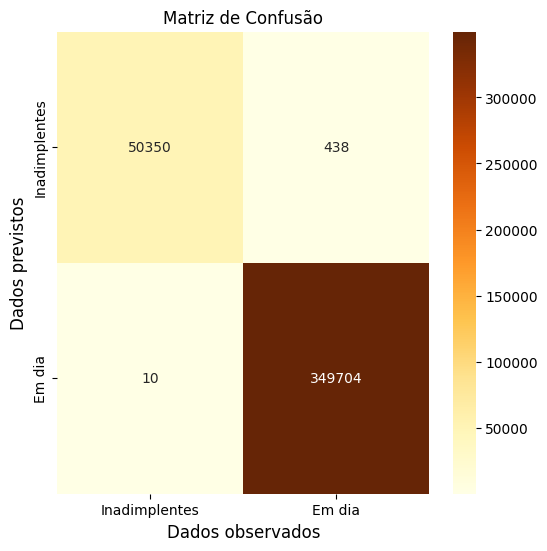

Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.
Carregando dados de validação.
Separando o target.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.
Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...

Realizando a previsão dos valores do banco de dados e calculando as métricas de avaliação.

Análise do modelo:

Valor métrica Accuracy:: 0.998478
Valor métrica Sensitividade (Recall): 0.991566
Valor métrica Especificidade: 0.999488
Valor métrica Precision: 0.996476
Tempo de cálculo 0:00:00.495318.




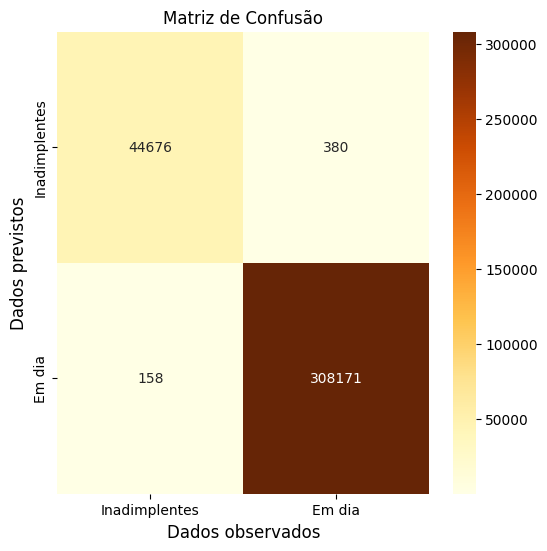

Treinamento Modelo CatBoost 20251204-1202 realizado com sucesso com um tempo total de 0:04:42.267123.


In [ ]:
#### MODELO 1. BOOSTING - CatBoost (CatBoostClassifier)
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

try:
    print('Iniciando timer geral e carregando banco de dados de treino.')
    inicio_geral = timer()
    try:
        if any(treino_x) or any(treino_y):
            print('Bancos de dados de treino e teste já existente, inibindo carregamento dos dados.\n')
    except:
        train_data, test_data = carregamento_treino(0.999999)
    
        print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
        historico, norm = parametros_zscore(train_data, norm=False)
        print('Informações calculadas, histórico mantido no objeto "historico".\n')
        tcc_zscore(train_data, norm)
        print('Normalização do banco de dados realizada, prosseguindo.\n')

       
        # ------ Separação dados de treino e teste
        print('Realizando procedimentos de separação de amostras para treino do modelo.')
        target = ['default']
        tamanho_treino = 0.8
        treino_x, teste_x, treino_y, teste_y = train_test_split(train_data, test_data, train_size=tamanho_treino, random_state=1)
        print('Liberando memória...')
        del train_data, test_data  # libera memória
        print('Pronto.\n')
        
        print(f'Número de observações para treino: {treino_x.shape[0]}')
        print(f'Número de observações para teste: {teste_x.shape[0]}\n')


    # ------ Parâmetros do modelo
    print('Estabelecendo parâmetros do algoritmo de treino.')
    nome_modelo = datetime.datetime.now().strftime("%Y%m%d-%H%M")  # I like to record the inicial time for the model's name at the end
    classif_cat = CatBoostClassifier(loss_function='Logloss', # https://catboost.ai/en/docs/concepts/loss-functions-classification#usage-information
                                    eval_metric = 'Logloss', # Logloss, AUC, MAPE, Poisson, Precision, Accuracy, R2, MedianAbsoluteError, PairAccuracy, PrecisionAt https://catboost.ai/en/docs/references/custom-metric__supported-metrics
                                    iterations = 1000,
                                    learning_rate = 0.01,
                                    random_seed = 1,
                                    bootstrap_type = 'MVS', #Bayesian (log), Bernoulli (stochastic), MVS (variance), Poisson (Poisson distribution)
                                    bagging_temperature = 7, 
                                    depth = 10,
                                    early_stopping_rounds = 500,
                                    thread_count = 12,
                                    task_type = 'CPU', 
                                    gpu_ram_part = 0.2,
                                    target_border = 0.5, 
                                    grow_policy = 'Lossguide', # Lossguide, Depthwise, SymmetricTree
                                    min_child_samples = 15, # default 1
                                    max_leaves = 20, # default 31
                                    boosting_type = 'Plain', # https://catboost.ai/en/docs/references/training-parameters/common#boosting_type
                                    score_function = 'L2' # L2, NewtonL2
                                    )


    # ------ Fitting do modelo
    print('Realizando treinamento do modelo...')
    inicio_treino = timer()
    classif_cat.fit(treino_x, treino_y,
                eval_set = (teste_x, teste_y),
                verbose = 100)
    fim_treino = timer()
    print(f'Modelo CatBoost {nome_modelo} treinado no tempo total de {timedelta(seconds=fim_treino-inicio_treino)}.\n')


    # ------ Cálculo das métricas do modelo com os dados de teste
    print('Métricas de avaliação utilizando banco de dados de TESTE...\n')
    pred_teste_cat = analise_metricas(classif=classif_cat, X=teste_x, y=teste_y, color='YlOrBr')


    # ------ Previsão e métricas com os dados de validação
    print('Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.')
    del treino_x, teste_x, treino_y
    print('Carregando dados de validação.')
    validacao = pd.read_parquet('data/validacao.parquet')
    print('Separando o target.')
    target = ['default']
    valid_y = validacao[target]
    valid_x = validacao.drop(target, axis=1)

    print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
    historico_valid, norm = parametros_zscore(valid_x, norm=False)
    print('Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.')
    tcc_zscore(valid_x, norm)
    print('Normalização do banco de dados realizada, prosseguindo.\n')


    # ------ Cálculo das métricas do modelo com os dados de validação
    print('Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...\n')
    pred_valid_cat = analise_metricas(classif=classif_cat, X=valid_x, y=valid_y, color='YlOrBr')


    # ------ Treinamento e resultados prontos
    fim_geral = timer()
    print(f'Treinamento Modelo CatBoost {nome_modelo} realizado com sucesso com um tempo total de {timedelta(seconds=fim_geral-inicio_geral)}.')

except Exception as e:
    print(f'Erro durante o processo de treinamento: {e}! Favor verificar.')

Iniciando timer geral e carregando banco de dados de treino.
Carregando banco de dados de treino completo...
Realizando redução das observações.
Liberando memória.
Realizando separação variáveis dependente e independentes.
Carregamento do banco de dados concluído.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico".

Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Realizando procedimentos de separação de amostras para treino do modelo.
Liberando memória...
Pronto.

Número de observações para treino: 1602006
Número de observações para teste: 400502

Estabelecendo parâmetros do algoritmo de treino.
Realizando treinamento do modelo...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000


[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   11.7s


building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000


[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:  1.2min


building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tre

[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:  2.9min


building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tre

[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:  5.2min


building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tre

[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:  8.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Modelo Random Forest 20251204-1211 treinado no tempo total de 0:08:09.439478.

Métricas de avaliação utilizando banco de dados de TESTE...

Realizando a previsão dos valores do banco de dados e calculando as métricas de avaliação.



[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    5.6s finished


Análise do modelo:

Valor métrica Accuracy:: 0.997471
Valor métrica Sensitividade (Recall): 0.980448
Valor métrica Especificidade: 0.999943
Valor métrica Precision: 0.999599
Tempo de cálculo 0:00:05.793376.




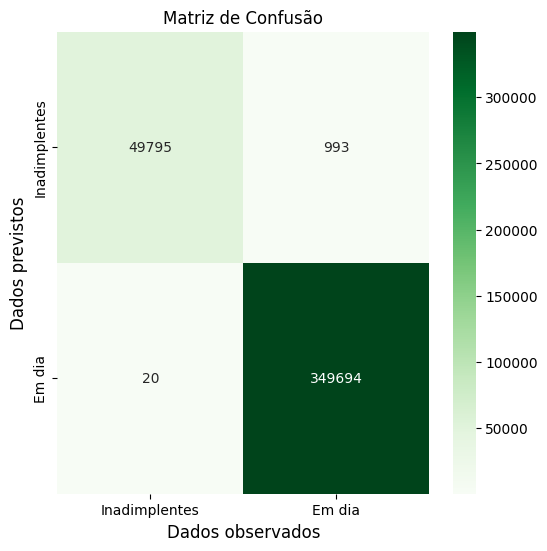

Realizando a previsão dos valores do banco de testes e calculando as métricas de avaliação.

Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.
Carregando dados de validação.
Separando o target.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.
Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...

Realizando a previsão dos valores do banco de dados e calculando as métricas de avaliação.



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    4.8s finished


Análise do modelo:

Valor métrica Accuracy:: 0.997391
Valor métrica Sensitividade (Recall): 0.979936
Valor métrica Especificidade: 0.999942
Valor métrica Precision: 0.999592
Tempo de cálculo 0:00:04.934009.




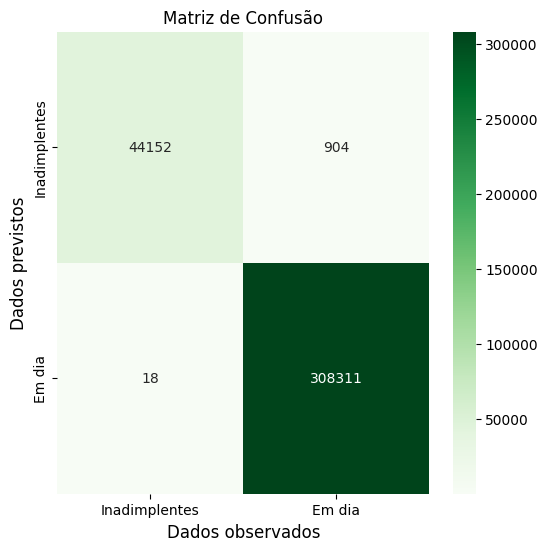

Treinamento Modelo Random Forest 20251204-1211 realizado com sucesso com um tempo total de 0:08:35.843255.


In [5]:
#### MODELO 2. RANDOM FOREST - RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

try:
    print('Iniciando timer geral e carregando banco de dados de treino.')
    inicio_geral = timer()
    try:
        if any(treino_x) or any(treino_y):
            print('Bancos de dados de treino e teste já existente, inibindo carregamento dos dados.\n')
    except:
        train_data, test_data = carregamento_treino(0.999999)
    
        print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
        historico, norm = parametros_zscore(train_data, norm=False)
        print('Informações calculadas, histórico mantido no objeto "historico".\n')
        tcc_zscore(train_data, norm)
        print('Normalização do banco de dados realizada, prosseguindo.\n')

       
        # ------ Separação dados de treino e teste
        print('Realizando procedimentos de separação de amostras para treino do modelo.')
        target = ['default']
        tamanho_treino = 0.8
        treino_x, teste_x, treino_y, teste_y = train_test_split(train_data, test_data, train_size=tamanho_treino, random_state=1)
        print('Liberando memória...')
        del train_data, test_data  # libera memória
        print('Pronto.\n')

        print(f'Número de observações para treino: {treino_x.shape[0]}')
        print(f'Número de observações para teste: {teste_x.shape[0]}\n')


    # ------ Parâmetros do modelo
    print('Estabelecendo parâmetros do algoritmo de treino.')
    nome_modelo = datetime.datetime.now().strftime("%Y%m%d-%H%M")
    classif_skl_rf = RandomForestClassifier(n_estimators = 1000,
                                            criterion = 'entropy', # 'gini' default, 'entropy', 'log_loss'
                                            max_depth = 21, # default None
                                            min_samples_split = 6, # default 2
                                            min_samples_leaf = 1, # default 1
                                            max_features='sqrt', # 'sqrt' default, 'log2, None
                                            bootstrap = True, # se 'False' usa o dataset inteiro para montar cada árvore
                                            oob_score = False, # Utilizado se bootstrep = True, usa uma métrica para o score geral (algo tipo r2score(y_true, y_pred))
                                            max_samples = 0.4, # usa com bootstrap = True, percentual de utilização amostral de X para treinar cada estimamdor
                                            n_jobs = 12,
                                            random_state = 1,
                                            verbose = 2,
                                            warm_start = False, # default, se True reutiliza a solução do último fit e adiciona mais estimadores ao agrupado
                                            )

    
    # ------ Fitting do modelo
    print('Realizando treinamento do modelo...')
    inicio_treino = timer()
    classif_skl_rf.fit(treino_x, treino_y)
    fim_treino = timer()
    print(f'Modelo Random Forest {nome_modelo} treinado no tempo total de {timedelta(seconds=fim_treino-inicio_treino)}.\n')


    # ------ Cálculo das métricas do modelo com os dados de teste
    print('Métricas de avaliação utilizando banco de dados de TESTE...\n')
    pred_teste_rf = analise_metricas(classif=classif_skl_rf, X=teste_x, y=teste_y, color='Greens')
    print('Realizando a previsão dos valores do banco de testes e calculando as métricas de avaliação.\n')


    # ------ Previsão e métricas com os dados de validação
    print('Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.')
    del treino_x, teste_x, treino_y#, teste_y
    print('Carregando dados de validação.')
    validacao = pd.read_parquet('data/validacao.parquet')
    print('Separando o target.')
    target = ['default']
    valid_y = validacao[target]
    valid_x = validacao.drop(target, axis=1)

    print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
    historico_valid, norm = parametros_zscore(valid_x, norm=False)
    print('Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.')
    tcc_zscore(valid_x, norm)
    print('Normalização do banco de dados realizada, prosseguindo.\n')

    # ------ Cálculo das métricas do modelo com os dados de validação
    print('Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...\n')
    pred_valid_rf = analise_metricas(classif=classif_skl_rf, X=valid_x, y=valid_y, color='Greens')


    # ------ Treinamento e resultados prontos
    fim_geral = timer()
    print(f'Treinamento Modelo Random Forest {nome_modelo} realizado com sucesso com um tempo total de {timedelta(seconds=fim_geral-inicio_geral)}.')

except Exception as e:
    print(f'Erro durante o processo de treinamento: {e}! Favor verificar.')

2025-12-04 12:19:32.618192: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-04 12:19:32.620844: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-04 12:19:32.625655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764850772.633458  151497 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764850772.635578  151497 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764850772.642172  151497 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Iniciando timer geral e carregando banco de dados de treino.
Carregando banco de dados de treino completo...
Realizando redução das observações.
Liberando memória.
Realizando separação variáveis dependente e independentes.
Carregamento do banco de dados concluído.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico".

Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Realizando procedimentos de separação de amostras para treino do modelo.
Liberando memória...
Pronto.

Número de observações para treino: 1602006
Número de observações para teste: 400502

Estabelecendo parâmetros do algoritmo de treino.
Realizando treinamento do modelo...


E0000 00:00:1764850801.115653  151497 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764850801.127141  151497 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/3


2025-12-04 12:20:02.004423: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1602006000 exceeds 10% of free system memory.


50063/50063 ━━━━━━━━━━━━━━━━━━━━ 42s 833us/step - categorical_hinge: 0.8813 - loss: 0.8813 - val_categorical_hinge: 0.8784 - val_loss: 0.8784
Epoch 2/3
50063/50063 ━━━━━━━━━━━━━━━━━━━━ 41s 824us/step - categorical_hinge: 0.8801 - loss: 0.8801 - val_categorical_hinge: 0.8800 - val_loss: 0.8800
Epoch 3/3
50063/50063 ━━━━━━━━━━━━━━━━━━━━ 42s 834us/step - categorical_hinge: 0.8797 - loss: 0.8797 - val_categorical_hinge: 0.8790 - val_loss: 0.8790
Modelo de Rede Neural 20251204-1220 treinado no tempo total de 0:02:07.091526.

Calculando accuracy e loss do modelo.
12516/12516 ━━━━━━━━━━━━━━━━━━━━ 7s 550us/step - categorical_hinge: 0.8790 - loss: 0.8790

Modelo treinado com metrics=categorical_hinge/count
Accuracy nos dados de treino (TensorFlow): 0.8789930939674377
Métricas de avaliação utilizando banco de dados de TESTE...

Realizando a previsão dos valores do banco de dados e calculando as métricas de avaliação.

12516/12516 ━━━━━━━━━━━━━━━━━━━━ 4s 356us/step
Análise do modelo:

Valor métri

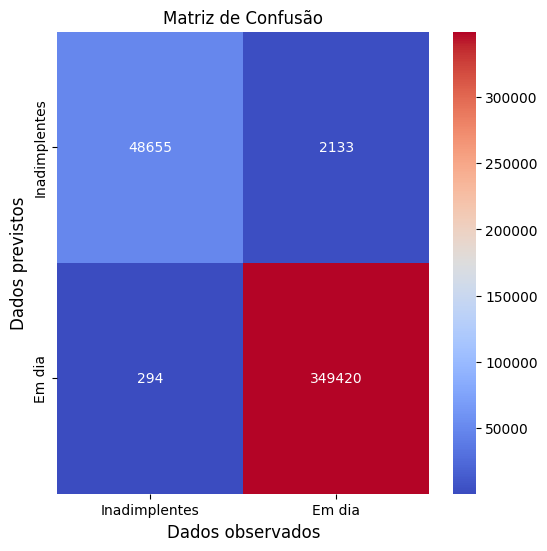

Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.
Carregando dados de validação.
Separando o target.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.
Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...

Realizando a previsão dos valores do banco de dados e calculando as métricas de avaliação.

11044/11044 ━━━━━━━━━━━━━━━━━━━━ 4s 351us/step
Análise do modelo:

Valor métrica Accuracy:: 0.993941
Valor métrica Sensitividade (Recall): 0.957875
Valor métrica Especificidade: 0.999212
Valor métrica Precision: 0.994401
Tempo de cálculo 0:00:06.936445.




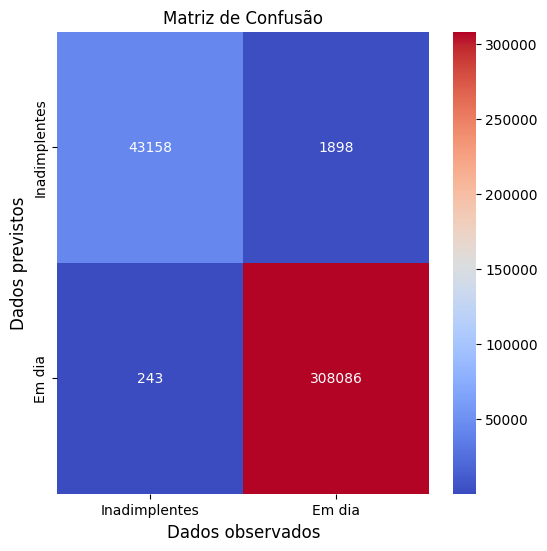

Treinamento Modelo de Rede Neural 20251204-1220 realizado com sucesso com um tempo total de 0:02:56.952935.


In [6]:
#### MODELO 3. REDE NEURAL
import tensorflow as tf
from tensorflow.keras.losses import categorical_hinge

try:
    print('Iniciando timer geral e carregando banco de dados de treino.')
    inicio_geral = timer()
    try:
        if any(treino_x) or any(treino_y):
            print('Bancos de dados de treino e teste já existente, inibindo carregamento dos dados.\n')
    except:
        train_data, test_data = carregamento_treino(0.999999)
    
        print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
        historico, norm = parametros_zscore(train_data, norm=False)
        print('Informações calculadas, histórico mantido no objeto "historico".\n')
        tcc_zscore(train_data, norm)
        print('Normalização do banco de dados realizada, prosseguindo.\n')

       
        # ------ Separação dados de treino e teste
        print('Realizando procedimentos de separação de amostras para treino do modelo.')
        target = ['default']
        tamanho_treino = 0.8
        treino_x, teste_x, treino_y, teste_y = train_test_split(train_data, test_data, train_size=tamanho_treino, random_state=1)
        print('Liberando memória...')
        del train_data, test_data  # libera memória
        print('Pronto.\n')

        print(f'Número de observações para treino: {treino_x.shape[0]}')
        print(f'Número de observações para teste: {teste_x.shape[0]}\n')        


    # ------ Parâmetros do modelo
    print('Estabelecendo parâmetros do algoritmo de treino.')
    nome_modelo = datetime.datetime.now().strftime("%Y%m%d-%H%M")
    classif_nn = tf.keras.Sequential()
    #modelo_dnn = keras.Sequential([normalizador])
    classif_nn.add(tf.keras.layers.Dense(64, activation='relu', name='Input_Dense64', input_shape=(treino_x.shape[1],)))
    classif_nn.add(tf.keras.layers.Dropout(0.3, seed=1))
    classif_nn.add(tf.keras.layers.Dense(32, activation='relu', name='Hidden1_Dense64', input_shape=(treino_x.shape[1],)))
    classif_nn.add(tf.keras.layers.Dense(1, activation='sigmoid', name='Output_Dense1'))
    classif_nn.compile(loss=categorical_hinge, 
                    optimizer='Adam',
                    metrics=['categorical_hinge'])

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  # callback de early stopping
                                            patience=3)


    # ------ Fitting do modelo
    print('Realizando treinamento do modelo...')
    inicio_treino = timer()
    classif_nn.fit(treino_x,
                            treino_y,
                            epochs=3,
                            validation_data=(teste_x, teste_y),
                            batch_size=32,
                            callbacks=[callback])
    fim_treino = timer()
    print(f'Modelo de Rede Neural {nome_modelo} treinado no tempo total de {timedelta(seconds=fim_treino-inicio_treino)}.\n')
    print('Calculando accuracy e loss do modelo.')
    loss, acc_tf = classif_nn.evaluate(teste_x, teste_y)
    print(f'\nModelo treinado com metrics={classif_nn.metrics_variables[-1].path}')
    print(f'Accuracy nos dados de treino (TensorFlow): {acc_tf}')

    # ------ Cálculo das métricas do modelo com os dados de teste
    print('Métricas de avaliação utilizando banco de dados de TESTE...\n')
    pred_teste_nn = analise_metricas(classif=classif_nn, X=teste_x, y=teste_y, color='coolwarm')


    # ------ Previsão e métricas com os dados de validação
    print('Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.')
    del treino_x, teste_x, treino_y#, teste_y
    print('Carregando dados de validação.')
    validacao = pd.read_parquet('data/validacao.parquet')
    print('Separando o target.')
    target = ['default']
    valid_y = validacao[target]
    valid_x = validacao.drop(target, axis=1)

    print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
    historico_valid, norm = parametros_zscore(valid_x, norm=False)
    print('Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.')
    tcc_zscore(valid_x, norm)
    print('Normalização do banco de dados realizada, prosseguindo.\n')


    # ------ Cálculo das métricas do modelo com os dados de validação
    print('Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...\n')
    pred_valid_nn = analise_metricas(classif=classif_nn, X=valid_x, y=valid_y, color='coolwarm')


    # ------ Treinamento e resultados prontos
    fim_geral = timer()
    print(f'Treinamento Modelo de Rede Neural {nome_modelo} realizado com sucesso com um tempo total de {timedelta(seconds=fim_geral-inicio_geral)}.')

except Exception as e:
    print(f'Erro durante o processo de treinamento: {e}! Favor verificar.')

Iniciando timer geral e carregando banco de dados de treino.
Carregando banco de dados de treino completo...
Realizando redução das observações.
Liberando memória.
Realizando separação variáveis dependente e independentes.
Carregamento do banco de dados concluído.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico".

Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Realizando procedimentos de separação de amostras para treino do modelo.
Liberando memória...
Pronto.

Número de observações para treino: 1602006
Número de observações para teste: 400502

Estabelecendo parâmetros do algoritmo de treino.
Realizando treinamento do modelo...
Modelo LDA 20251204-1222 treinado no tempo total de 0:01:18.789765.

Métricas de avaliação utilizando banco de dados de T

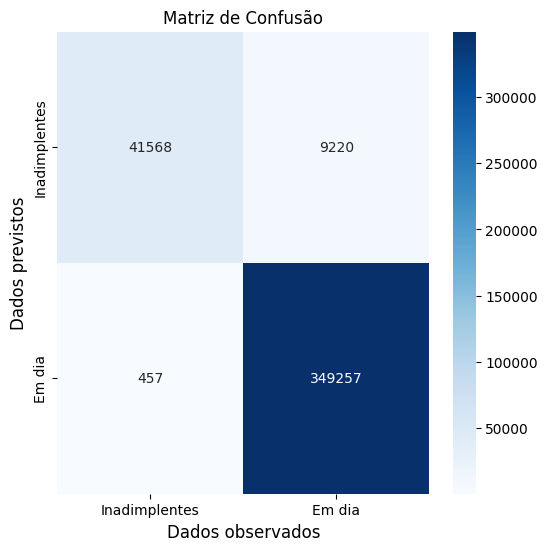

Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.
Carregando dados de validação.
Separando o target.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.
Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...

Realizando a previsão dos valores do banco de dados e calculando as métricas de avaliação.

Análise do modelo:

Valor métrica Accuracy:: 0.975684
Valor métrica Sensitividade (Recall): 0.817982
Valor métrica Especificidade: 0.998729
Valor métrica Precision: 0.989476
Tempo de cálculo 0:00:01.469969.




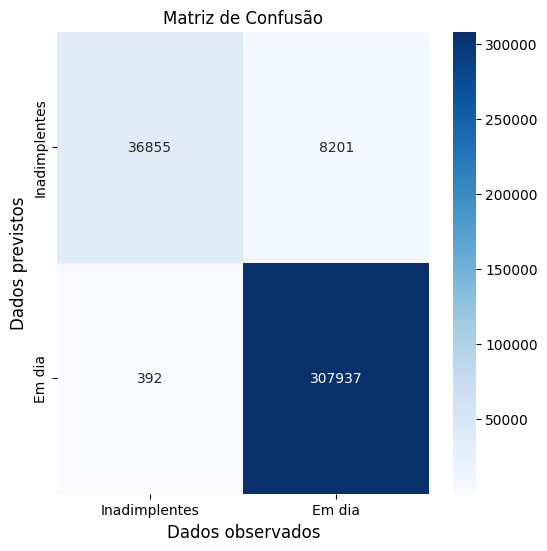

Treinamento Modelo LDA 20251204-1222 realizado com sucesso com um tempo total de 0:01:40.035661.


In [7]:
#### MODELO 4. LDA - LINEAR DISCRIMINANT ANALYSIS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

try:
    print('Iniciando timer geral e carregando banco de dados de treino.')
    inicio_geral = timer()
    try:
        if any(treino_x) or any(treino_y):
            print('Bancos de dados de treino e teste já existente, inibindo carregamento dos dados.\n')
    except:
        train_data, test_data = carregamento_treino(0.999999)
    
        print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
        historico, norm = parametros_zscore(train_data, norm=False)
        print('Informações calculadas, histórico mantido no objeto "historico".\n')
        tcc_zscore(train_data, norm)
        print('Normalização do banco de dados realizada, prosseguindo.\n')

       
        # ------ Separação dados de treino e teste
        print('Realizando procedimentos de separação de amostras para treino do modelo.')
        target = ['default']
        tamanho_treino = 0.8
        treino_x, teste_x, treino_y, teste_y = train_test_split(train_data, test_data, train_size=tamanho_treino, random_state=1)
        print('Liberando memória...')
        del train_data, test_data  # libera memória
        print('Pronto.\n')

        print(f'Número de observações para treino: {treino_x.shape[0]}')
        print(f'Número de observações para teste: {teste_x.shape[0]}\n')


    # ------ Parâmetros do modelo
    print('Estabelecendo parâmetros do algoritmo de treino.')
    nome_modelo = datetime.datetime.now().strftime("%Y%m%d-%H%M")  # I like to record the inicial time for the model's name at the end
    classif_lda = lda()


    # ------ Fitting do modelo
    print('Realizando treinamento do modelo...')
    inicio_treino = timer()
    classif_lda.fit(treino_x, treino_y)
    fim_treino = timer()
    print(f'Modelo LDA {nome_modelo} treinado no tempo total de {timedelta(seconds=fim_treino-inicio_treino)}.\n')


    # ------ Cálculo das métricas do modelo com os dados de teste
    print('Métricas de avaliação utilizando banco de dados de TESTE...\n')
    pred_teste_lda = analise_metricas(classif=classif_lda, X=teste_x, y=teste_y, color='Blues')


    # ------ Previsão e métricas com os dados de validação
    print('Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.')
    del treino_x, teste_x, treino_y#, teste_y
    print('Carregando dados de validação.')
    validacao = pd.read_parquet('data/validacao.parquet')
    print('Separando o target.')
    target = ['default']
    valid_y = validacao[target]
    valid_x = validacao.drop(target, axis=1)

    print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
    historico_valid, norm = parametros_zscore(valid_x, norm=False)
    print('Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.')
    tcc_zscore(valid_x, norm)
    print('Normalização do banco de dados realizada, prosseguindo.\n')


    # ------ Cálculo das métricas do modelo com os dados de validação
    print('Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...\n')
    pred_valid_lda = analise_metricas(classif=classif_lda, X=valid_x, y=valid_y, color='Blues')


    # ------ Treinamento e resultados prontos
    fim_geral = timer()
    print(f'Treinamento Modelo LDA {nome_modelo} realizado com sucesso com um tempo total de {timedelta(seconds=fim_geral-inicio_geral)}.')

except Exception as e:
    print(f'Erro durante o processo de treinamento: {e}! Favor verificar.')

Iniciando timer geral e carregando banco de dados de treino.
Carregando banco de dados de treino completo...
Realizando redução das observações.
Liberando memória.
Realizando separação variáveis dependente e independentes.
Carregamento do banco de dados concluído.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico".

Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Realizando procedimentos de separação de amostras para treino do modelo.
Liberando memória...
Pronto.

Número de observações para treino: 1602006
Número de observações para teste: 400502

Estabelecendo parâmetros do algoritmo de treino.
Realizando treinamento do modelo...
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1889.153282, rho = -0.429811
nSV 

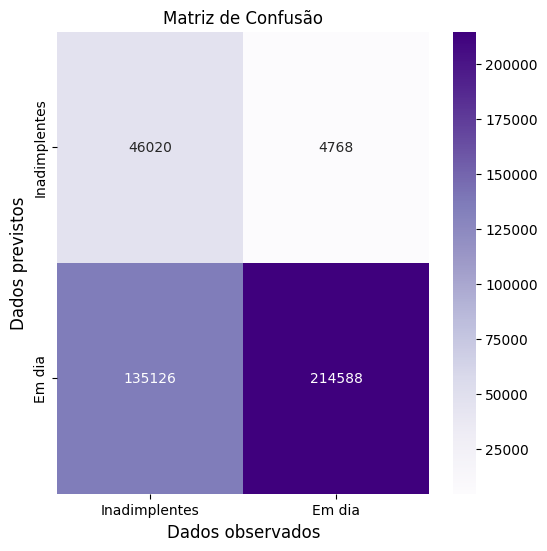

Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.
Carregando dados de validação.
Separando o target.
Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas
Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.
Iniciando processo de normalização.

Processo de normalização concluído com sucesso!
Normalização do banco de dados realizada, prosseguindo.

Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...

Realizando a previsão dos valores do banco de dados e calculando as métricas de avaliação.

Análise do modelo:

Valor métrica Accuracy:: 0.649991
Valor métrica Sensitividade (Recall): 0.904363
Valor métrica Especificidade: 0.612819
Valor métrica Precision: 0.254468
Tempo de cálculo 0:01:10.630878.




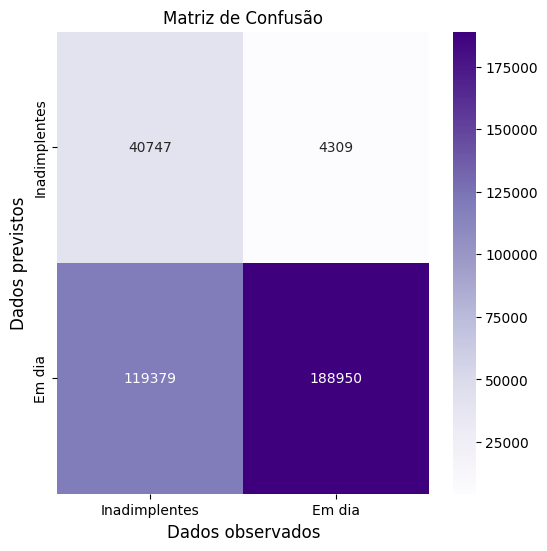

Treinamento Modelo SVM 20251204-1224 realizado com sucesso com um tempo total de 0:08:28.882553.


In [8]:
#### MODELO 5. SVM - SUPPORT VECTOR MACHINE
from sklearn.svm import SVC

try:
    print('Iniciando timer geral e carregando banco de dados de treino.')
    inicio_geral = timer()
    try:
        if any(treino_x) or any(treino_y):
            print('Bancos de dados de treino e teste já existente, inibindo carregamento dos dados.\n')
    except:
        train_data, test_data = carregamento_treino(0.999999)
    
        print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
        historico, norm = parametros_zscore(train_data, norm=False)
        print('Informações calculadas, histórico mantido no objeto "historico".\n')
        tcc_zscore(train_data, norm)
        print('Normalização do banco de dados realizada, prosseguindo.\n')

       
        # ------ Separação dados de treino e teste
        print('Realizando procedimentos de separação de amostras para treino do modelo.')
        target = ['default']
        tamanho_treino = 0.8
        treino_x, teste_x, treino_y, teste_y = train_test_split(train_data, test_data, train_size=tamanho_treino, random_state=1)
        print('Liberando memória...')
        del train_data, test_data  # libera memória
        print('Pronto.\n')

        print(f'Número de observações para treino: {treino_x.shape[0]}')
        print(f'Número de observações para teste: {teste_x.shape[0]}\n')


    # ------ Parâmetros do modelo
    print('Estabelecendo parâmetros do algoritmo de treino.')
    nome_modelo = datetime.datetime.now().strftime("%Y%m%d-%H%M")
    classif_svm = SVC(verbose=True,
                    max_iter=1000,
                    random_state=1)


    # ------ Fitting do modelo
    print('Realizando treinamento do modelo...')
    inicio_treino = timer()
    classif_svm.fit(treino_x, treino_y)
    fim_treino = timer()    
    print(f'Modelo SVM {nome_modelo} treinado no tempo total de {timedelta(seconds=fim_treino-inicio_treino)}.\n')


    # ------ Cálculo das métricas do modelo com os dados de teste
    print('Métricas de avaliação utilizando banco de dados de TESTE...\n')
    pred_teste_svm = analise_metricas(classif=classif_svm, X=teste_x, y=teste_y, color='Purples')


    # ------ Previsão e métricas com os dados de validação
    print('Análise dos dados de teste realizada. Limpando memória para verificação com dados de validação.')
    del treino_x, teste_x, treino_y#, teste_y
    print('Carregando dados de validação.')
    validacao = pd.read_parquet('data/validacao.parquet')
    print('Separando o target.')
    target = ['default']
    valid_y = validacao[target]
    valid_x = validacao.drop(target, axis=1)

    print('Calculando dados de média e desvio padrão antes da padronização no banco de dados. Também registrando o nome das features utilizadas')
    historico_valid, norm = parametros_zscore(valid_x, norm=False)
    print('Informações calculadas, histórico mantido no objeto "historico_valid". Realizando procedimento de normalização das features.')
    tcc_zscore(valid_x, norm)
    print('Normalização do banco de dados realizada, prosseguindo.\n')


    # ------ Cálculo das métricas do modelo com os dados de teste
    print('Métricas de avaliação utilizando banco de dados de VALIDAÇÃO...\n')
    pred_valid_svm = analise_metricas(classif=classif_svm, X=valid_x, y=valid_y, color='Purples')


    # ------ Treinamento e resultados prontos
    fim_geral = timer()
    print(f'Treinamento Modelo SVM {nome_modelo} realizado com sucesso com um tempo total de {timedelta(seconds=fim_geral-inicio_geral)}.')


except Exception as e:
    print(f'Erro durante o processo de treinamento: {e}! Favor verificar.')

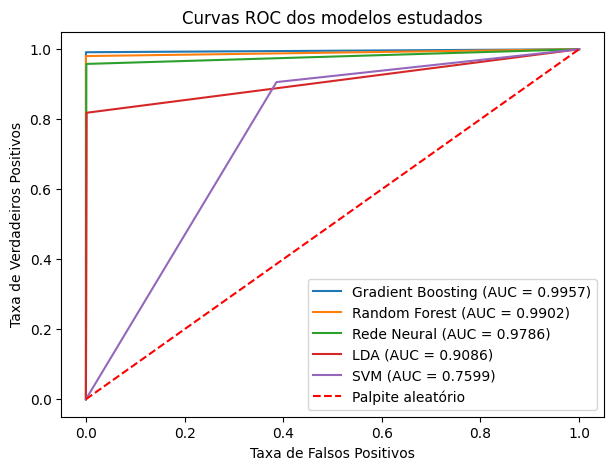

In [ ]:
# Curvas ROC_AUC para todos os modelos juntos
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7, 5))

rel = {'Gradient Boosting':pred_teste_cat,
       'Random Forest':pred_teste_rf,
       'Rede Neural': pred_teste_nn,
       'LDA':pred_teste_lda,
       'SVM':pred_teste_svm}

for model in rel:
    fpr, tpr, _ = roc_curve(teste_y, rel[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'r--', label='Palpite aleatório')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC dos modelos estudados')
plt.legend()
plt.show()